<a href="https://colab.research.google.com/github/lollomante/ML_Cats/blob/main/Gina_vs_Shiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gina vs Shiro

## Import libraries

In [128]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import itertools
from tensorflow import keras
from keras import layers
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Constants and parameters

In [129]:
# loadind dataset parameters
Path_to_train_dataset   = '/content/drive/MyDrive/ML - Cats/Gina vs Shiro/training_validation'
Path_to_test_dataset    = '/content/drive/MyDrive/ML - Cats/Gina vs Shiro/test'
validation_split_ratio  = 0.2
seed                    = 69   # a nice seed
import_batch_size       = None
do_testing              = True # if false, skips the testing phase
skip_plots              = False # if true, skips the plots phase

# dataset parameters
image_sizes             = (150,150,3) # size to crop images
batch_size              = 32

# model parameters
apply_fine_tuning       = False
model_optimizer         = 'adam'
numer_of_epochs         = 4
dropout_rate            = 0.2


## Load dataset and split

In [130]:
drive.mount('/content/drive')
# Load the training dataset
learning_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  Path_to_train_dataset,
                  validation_split=validation_split_ratio,
                  subset="training",
                  seed=seed,
                  batch_size=import_batch_size
                )

# Load the validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  Path_to_train_dataset,
                  validation_split=validation_split_ratio,
                  subset="validation",
                  seed=seed,
                  batch_size=import_batch_size
                )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 255 files belonging to 2 classes.
Using 204 files for training.
Found 255 files belonging to 2 classes.
Using 51 files for validation.


## Explore dataset

### Number of samples

In [131]:
# TODO: deal with non full batches
batch_size = import_batch_size
if (batch_size == None):
    batch_size = 1
print('Number of training samples: %d' %(int(tf.data.experimental.cardinality(learning_dataset))*batch_size))
print('Number of validation samples: %d' %(int(tf.data.experimental.cardinality(validation_dataset))*batch_size))


Number of training samples: 204
Number of validation samples: 51


### Show some samples of the dataset

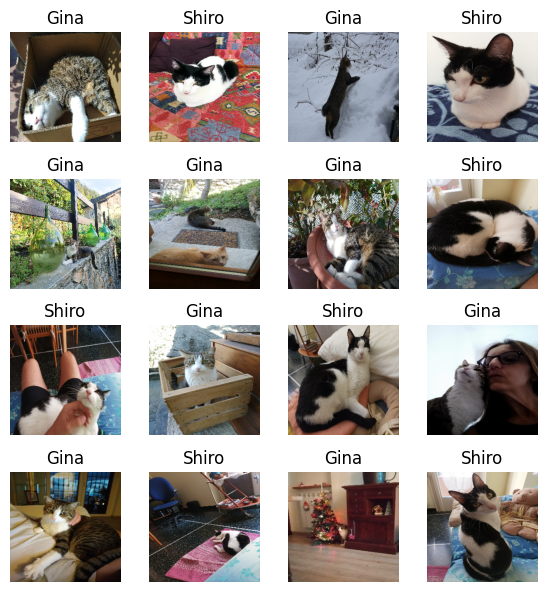

In [132]:
if not(skip_plots):
  n_rows = 4 # columns of the subplpots
  n_cols = 4 # rows of the subplots
  plt.figure(figsize=(6,6)) # size of images
  for i, (img,label) in enumerate(learning_dataset.take(n_rows*n_cols)):
      plt.subplot(n_rows,n_cols,i+1)
      plt.imshow(img/255) # normlalize images
      plt.axis('off') # remove axis
      plt.tight_layout(pad=1.0) # add padding between images
      plt.title('Gina' if not(label) else 'Shiro') # set lables
  plt.show()

## Process the dataset

### Resize images

In [133]:
learning_dataset    = learning_dataset.map(lambda x,y: (tf.image.resize(x,image_sizes[:2]),y))
validation_dataset  = validation_dataset.map(lambda x,y: (tf.image.resize(x,image_sizes[:2]),y))

### Visualize cropped images

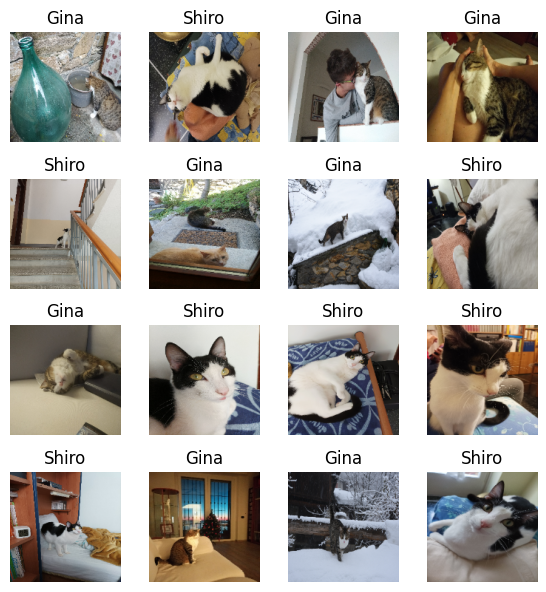

In [134]:
if not(skip_plots):
  n_rows = 4 # columns of the subplpots
  n_cols = 4 # rows of the subplots
  plt.figure(figsize=(6,6)) # size of images
  for i, (img,label) in enumerate(learning_dataset.take(n_rows*n_cols)):
      plt.subplot(n_rows,n_cols,i+1)
      plt.imshow(img/255) # normlalize images
      plt.axis('off') # remove axis
      plt.tight_layout(pad=1.0) # add padding between images
      plt.title('Gina' if not(label) else 'Shiro') # set lables
  plt.show()

### Apply batching

In [135]:
learning_dataset = learning_dataset.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

### Define data agumentation

In [136]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
])

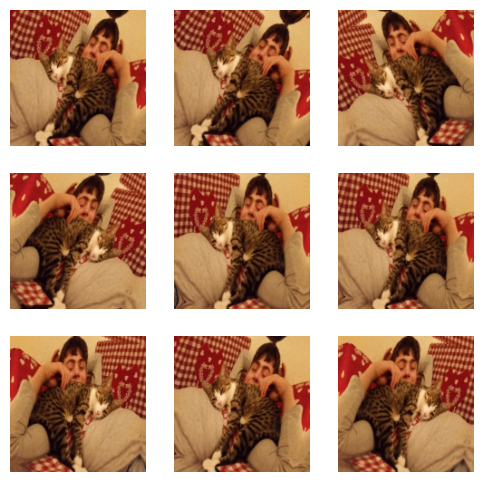

In [137]:
if not(skip_plots):
  n_rows = 3  # columns of the subplpots
  n_cols = 3 # rows of the subplots
  plt.figure(figsize=(6,6)) # size of images
  for i, (img,label) in enumerate(learning_dataset.take(1)):
      img = img[0]
      for i in range(n_rows*n_cols):
        plt.subplot(n_rows,n_cols,i+1)
        aug_img = data_augmentation(tf.expand_dims(img,0),training=True)
        plt.imshow(aug_img[0]/255) # normlalize images
        plt.axis('off') # remove axis
  plt.show()

## Train the model

In [138]:
pretrained_model = keras.applications.Xception(
    weights='imagenet',       # pre traines weights
    input_shape=image_sizes,  # shape of input
    include_top=False         # do not include top fully connected layer
)

# use or not fine tuning
pretrained_model.trainable = apply_fine_tuning

# define input
input = keras.Input(shape=image_sizes)

# apply data agumentation
x = data_augmentation(input)

# normalize and scale imput (from [0 255] to [-1 1])
x = keras.layers.Rescaling(scale=1./(255/2),offset=-1)(x)

# apply the pretrained model
x = pretrained_model(x)

# apply global average pooling to reduce number of parameters
x = keras.layers.GlobalAveragePooling2D()(x)

# apply dropout
x = keras.layers.Dropout(dropout_rate)(x)

# apply a dense layer
output = keras.layers.Dense(1)(x)

# define the model
model = keras.Model(inputs = input, outputs = output)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [139]:
model.compile(
    optimizer = model_optimizer,

    # using binary cross entropy because we don't apply a softmax
    loss      = keras.losses.BinaryCrossentropy(from_logits=True),

    # apply binary acuracy (because it is binary classification)
    metrics   = [keras.metrics.BinaryAccuracy()]
)

In [140]:
model.fit(
    learning_dataset,
    epochs=numer_of_epochs,
    validation_data=validation_dataset
)

Epoch 1/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - binary_accuracy: 0.7793 - loss: 0.4503 - val_binary_accuracy: 0.9216 - val_loss: 0.2010
Epoch 2/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - binary_accuracy: 0.9618 - loss: 0.1290 - val_binary_accuracy: 0.9608 - val_loss: 0.1707
Epoch 3/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - binary_accuracy: 0.9795 - loss: 0.0844 - val_binary_accuracy: 0.9216 - val_loss: 0.1687
Epoch 4/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.9488 - loss: 0.0978 - val_binary_accuracy: 0.9412 - val_loss: 0.1908


## Testing phase

### Load the testing dataset

In [141]:
# Load the testing dataset
if (do_testing):
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        Path_to_test_dataset,
        seed=seed,
        batch_size=import_batch_size,
        image_size=image_sizes[:2],
        shuffle=True
    )

    # Save class names before modifying the dataset
    class_names = test_dataset.class_names

    print('Number of testing samples: %d' %(int(tf.data.experimental.cardinality(test_dataset))*batch_size))

Found 20 files belonging to 2 classes.
Number of testing samples: 20


### Batch and prepare the testing dataset

In [142]:
if (do_testing):
    # === Resize and batch test data ===
    test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, image_sizes[:2]), y))
    batched_test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Make the predictions

In [143]:
if (do_testing):
    y_true = []
    y_pred = []

    for images, labels in batched_test_dataset:
        logits = model(images, training=False)
        probs = tf.nn.sigmoid(logits)             # apply sigmoid to get probabilities
        preds = tf.where(probs > 0.5, 1, 0)       # threshold at 0.5 for binary classification
        y_true.extend(labels.numpy())             # store true label
        y_pred.extend(preds.numpy().flatten())    # store predicted labels

### Plot confusion matrix

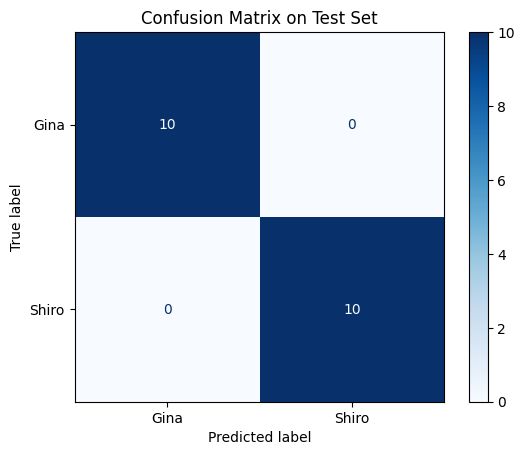

In [144]:
if (do_testing and not(skip_plots)):
    # === Confusion matrix ===
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gina', 'Shiro'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix on Test Set")
    plt.show()

### Plot some predictions

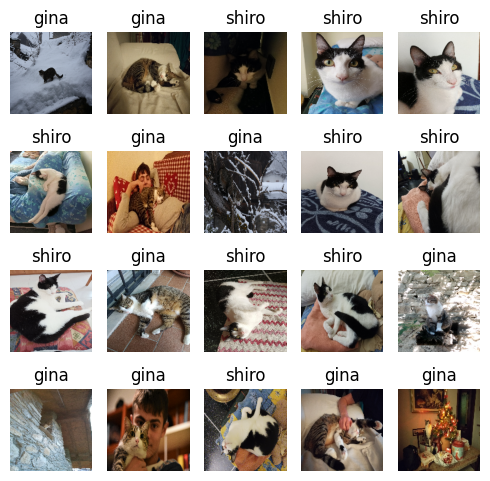

In [145]:
if (do_testing and not(skip_plots)):
    n_rows = 4 # columns of the subplpots
    n_cols = 5 # rows of the subplots
    plt.figure(figsize=(5, 5))

    # Get a batch of N images from the test set
    image_batch = next(iter(batched_test_dataset.unbatch().batch(n_rows * n_cols)))
    images, labels = image_batch[0], image_batch[1]

    logits = model(images, training=False)
    probs = tf.nn.sigmoid(logits)
    preds = tf.where(probs > 0.5, 1, 0).numpy().flatten()

    for i in range(n_rows * n_cols):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[preds[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### Test error summary

In [146]:
if (do_testing):
    total_samples = len(y_true)
    num_wrong = np.sum(np.array(y_true) != np.array(y_pred))
    error_rate = num_wrong / total_samples

    print(f"\nTest Error Rate: {num_wrong} / {total_samples} = {error_rate:.2%}")


Test Error Rate: 0 / 20 = 0.00%


## Notes:
+ applying fine tuning ``` apply_fine_tuning = True``` drastically worsen accuracy (from 0.98 to 0.62)
+ increasig number of epochs from 4 to 7 ``` numer_of_epochs = 7``` does not change much the result
+ using the optimizer ```keras.optimizers.Adam(0.00001)``` gives a worst result
+ using the optimizer ```keras.optimizers.Adam(0.001)``` gives a similar result to 'adam'
+ using the optimizer ```keras.optimizers.Adam(0.01)``` and ``` numer_of_epochs = 7``` causes overfitting


